In [1]:
from z3 import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import _tree, plot_tree
import pandas as pd
from matplotlib import pyplot as plt
import re
import json
import tqdm
import xgboost

In [4]:
from utils import *

In [5]:
data = load_breast_cancer()
X = data['data']
y = data["target"]
feature_names = data["feature_names"]
y = y==1

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
ntrees = 50
clf = xgboost.XGBClassifier(n_estimators=ntrees, max_depth=3).fit(x_train, y_train)
clf.score(x_test, y_test)

0.956140350877193

In [8]:
dump = clf.get_booster().get_dump(dump_format="json")
all_thresh = get_ens_thresh(dump)
data_ = disc_data(x_train[:2,:], all_thresh)
print(data_.shape)
data_.head()

(2, 128)


,12_1.75900006,5_0.0604199991,26_0.207249999,7_0.0512799993,24_0.135199994,27_0.135800004,27_0.135049999,27_0.110849999,6_0.0721400008,10_0.643100023,...,9_0.0564949997,22_114.449997,24_0.10915,23_711.300049,21_25.7449989,21_25.5649986,21_25.5149994,28_0.28095001,15_0.0177699998,23_871.799988
0,False,True,True,True,True,True,True,True,True,False,...,True,False,True,True,True,True,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [9]:
var_x = {f"x({i})": Bool(f"x({i})") for i in data_.columns}

# Soft Attack

In [10]:
epsilon = 0.34
index = 12

sample = X[index:index+1, :]
clf.predict_proba(sample)

array([[0.9875099 , 0.01249008]], dtype=float32)

In [11]:
s, c_weights = soft_attack(clf, sample, epsilon, var_x)

False
sat


In [12]:
adv_weights = get_output(s, c_weights)
1 / (1 + np.exp(-np.sum([v for k, v in adv_weights.items()])))

0.8113696529314206

In [13]:
clf.predict_proba(sample)[0][1]

0.0124900825

In [14]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.81136966

In [15]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
28,0.317600,0.210089,0.338510,"[0.199349999, 0.210099995]"
23,1332.000000,884.537238,0.335933,"[871.799988, 884.549988]"
21,29.940000,20.043360,0.330549,"[18.4049988, 20.0450001]"
1,24.800000,16.609116,0.330278,"[15.7250004, 16.6100006]"
10,0.955500,0.643041,0.327011,"[0.583999991, 0.643100023]"
20,20.960000,14.415570,0.312234,"[-inf, 14.4300003]"
22,151.700000,105.946097,0.301608,"[102.050003, 105.949997]"
26,0.363900,0.260458,0.284261,"[0.218050003, 0.260500014]"
2,132.400000,102.147750,0.228491,"[-inf, 102.25]"
0,19.170000,14.965020,0.219352,"[-inf, 14.9799995]"


# Hard Attack

## weight distribution

In [16]:
w = np.asarray([v for k,v in c_weights.items()])
w.min(), w.max()

(-0.194285721, 0.190977439)

(array([ 3., 11., 52., 34., 67., 49., 53., 45., 10.,  3.]),
 array([-0.19428572, -0.1557594 , -0.11723309, -0.07870677, -0.04018046,
        -0.00165414,  0.03687217,  0.07539849,  0.11392481,  0.15245112,
         0.19097744]),
 <a list of 10 Patch objects>)

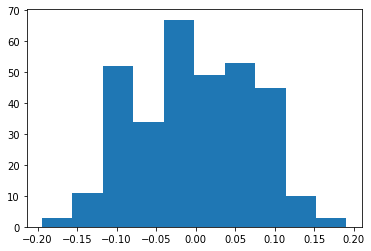

In [17]:
plt.hist(w)

## Attacking sample

In [18]:
epsilon = 0.34
index = 12

nbits = 8
sample = X[index:index+1, :]

In [19]:
s, c_weights, seq_nump, seq_numn = hard_attack(clf, sample, epsilon, var_x, nbits)

False
sat


In [20]:
clf.predict_proba(sample)[0][1]

0.0124900825

In [21]:
adv_weights = get_output(s, c_weights)
val = np.sum([v for k, v in adv_weights.items()])
1 / (1 + np.exp(-val))

0.6414845597690458

In [22]:
x_adv, x_adv_sample, compare = get_x_adv(s, var_x, sample)
clf.predict_proba(x_adv_sample)[0][1]

0.64148456

In [23]:
compare.sort_values(by=["diff(%)"], ascending=False)

,0,1,diff(%),bound
23,1332.000000,884.537238,0.335933,"[871.799988, 884.549988]"
21,29.940000,20.043360,0.330549,"[18.4049988, 20.0450001]"
1,24.800000,16.609116,0.330278,"[15.7250004, 16.6100006]"
26,0.363900,0.260458,0.284261,"[0.218050003, 0.260500014]"
22,151.700000,114.441497,0.245606,"[105.949997, 114.449997]"
27,0.176700,0.135026,0.235846,"[0.111000001, 0.135049999]"
2,132.400000,102.147750,0.228491,"[-inf, 102.25]"
7,0.111800,0.090986,0.186169,"[0.0723399967, 0.0910049975]"
0,19.170000,15.859125,0.172711,"[-inf, 15.875]"
28,0.317600,0.269380,0.151826,"[0.199349999, 0.269450009]"
